In [1]:
import os
import pickle
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import enlighten

from IPython.core.display import HTML
from IPython.display import SVG, Image, display

#RDKit related imports
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import Draw

#scikit imports
from sklearn.model_selection import train_test_split

#tensorflow
import tensorflow as tf
from tensorflow import keras
import tensorflow_decision_forests as tfdf

RDLogger.logger().setLevel(RDLogger.CRITICAL)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.test.gpu_device_name()))

Num GPUs Available:  13


2022-08-12 15:42:24.886715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-12 15:42:24.916996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 15:42:24.944653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 15:42:24.944778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))


In [4]:
not_used_desc = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'Ipc']
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])



In [5]:
cols = pd.read_csv('backup_df.csv', nrows=1).columns
dataframe = pd.read_csv('backup_df.csv', index_col=False, usecols=cols[1:])

In [7]:
PandasTools.AddMoleculeColumnToFrame(dataframe, 'PUBCHEM_CANONICAL_SMILES', 'ROMol', includeFingerprints=True)

In [8]:
RF_dataset = dataframe.copy()

In [9]:
mol_descs = []
activity_binary = []
activity_regressor = []
ECFP6s = []
topols = []
atom_pairs = []



pbar = enlighten.Counter(total=len(RF_dataset.index), desc='Calculating molecular descriptors', unit='ticks')

for ID, row in RF_dataset.iterrows():
    # print(i)
    nan_flag = False

    mol = row.ROMol# if i == max_radius else row[f'FRAG_R{i}']          
    descriptor = desc_calc.CalcDescriptors(mol)
    for j in descriptor:
        if np.isnan(j):
            nan_flag = True
            break 
    if nan_flag:
        print(ID)
        print(f'Line {ID} contains NaN values, removing...')
        RF_dataset.drop(ID, inplace=True)
        continue

    ECFP6_vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=3)
    topol_vec =  Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)
    atpair_vec = Chem.GetHashedAtomPairFingerprintAsBitVect(mol)

    ECFP6s.append(ECFP6_vec)
    topols.append(topol_vec)
    atom_pairs.append(atpair_vec)



    # print(descriptor)
    mol_descs.append(descriptor)
    activity_binary.append(row.PUBCHEM_ACTIVITY_OUTCOME)
    activity_regressor.append(row.PUBCHEM_ACTIVITY_SCORE)
    pbar.update()

9561
Line 9561 contains NaN values, removing...
9637
Line 9637 contains NaN values, removing...
9644
Line 9644 contains NaN values, removing...
9667
Line 9667 contains NaN values, removing...
9669
Line 9669 contains NaN values, removing...
9693
Line 9693 contains NaN values, removing...
9701
Line 9701 contains NaN values, removing...
9708
Line 9708 contains NaN values, removing...
9709
Line 9709 contains NaN values, removing...
9722
Line 9722 contains NaN values, removing...
9967
Line 9967 contains NaN values, removing...
18834
Line 18834 contains NaN values, removing...
19009
Line 19009 contains NaN values, removing...
19021
Line 19021 contains NaN values, removing...
19039
Line 19039 contains NaN values, removing...
19051
Line 19051 contains NaN values, removing...
23705
Line 23705 contains NaN values, removing...
37288
Line 37288 contains NaN values, removing...
38542
Line 38542 contains NaN values, removing...
38557
Line 38557 contains NaN values, removing...
48679
Line 48679 conta

In [ ]:
activities = RF_dataset["PUBCHEM_ACTIVITY_OUTCOME"].to_list()

In [ ]:
act_bin_vec = []

for i in activities:
    if i == 'Active':
        act_bin_vec.append(1)
    elif i == 'Inactive':
        act_bin_vec.append(0)
    else:
        print("Invalid data in array, remove all non Active/Inactive cells")

In [ ]:
encodings = [mol_descs, ECFP6s, topols, atom_pairs]
enc_names = ['descriptors', 'ecfp6s', 'topols', 'at_pairs']

enc_arrays = []

for i in encodings:
    array = np.array(i, dtype=np.float64)
    enc_arrays.append(array)


In [ ]:
enc_DFs = []

for i in enc_arrays:
    df = pd.DataFrame(i)
    # df['PUBCHEM_ACTIVITY_OUTCOME'] = activity_binary
    enc_DFs.append(df)



In [ ]:
# enc_DFs[1]

In [ ]:
act_bin_vec = []

for i in activity_binary:
    if i == 'Active':
        act_bin_vec.append(1)
    elif i == 'Inactive':
        act_bin_vec.append(0)
    else:
        print("Invalid data in array, remove all non Active/Inactive cells")

        

In [ ]:
model_datasets = []

for i in enc_DFs:
    spl_df = i.to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(i, act_bin_vec, random_state=20)
    train_df = pd.DataFrame(x_train)
    train_df['PUBCHEM_ACTIVITY_OUTCOME'] = y_train
    test_df = pd.DataFrame(x_test)
    test_df['PUBCHEM_ACTIVITY_OUTCOME'] = y_test

    tpl_df = (train_df, test_df)
    model_datasets.append(tpl_df)



In [ ]:
# #train the models

# for ID, i in enumerate(model_datasets):
#     run_RF_model(models[ID], train_data=i[0], test_data=i[1])


In [ ]:
#parameters
NUM_TREES = 5000

MIN_EXAMPLES = 6

MAX_DEPTH = 5

SUBSAMPLE = 0.65

SAMPLING_METHOD = "RANDOM"

VALIDATION_RATIO = 0.1

In [ ]:
def run_RF_model(model, train_data, test_data, num_epochs=1, batch_size=1):
    train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label='PUBCHEM_ACTIVITY_OUTCOME'
    )
    test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        test_data, label='PUBCHEM_ACTIVITY_OUTCOME'
    )
    model.fit(train_dataset, epochs=num_epochs, batch_size=batch_size)
    _, accuracy = model.evaluate(test_dataset, verbose=0)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
def show_feature_usage():
    feature_usages = []

    #there are only numerical descriptors
    for feature_name in desc_calc.descriptorNames:
        usage = tfdf.keras.FeatureUsage(name=feature_name, semantic=tfdf.keras.FeatureSemantic.NUMERICAL)
        feature_usages.append(usage)

    return feature_usages

In [ ]:
def create_GBT_model(name):
    gbt_model = tfdf.keras.GradientBoostedTreesModel(
        features=show_feature_usage(),
        exclude_non_specified_features=True,
        num_trees=NUM_TREES,
        max_depth=MAX_DEPTH,
        min_examples=MIN_EXAMPLES,
        subsample=SUBSAMPLE,
        validation_ratio=VALIDATION_RATIO,
        task=tfdf.keras.Task.CLASSIFICATION,
        name=name,
    )
    gbt_model.compile(metrics=[keras.metrics.BinaryAccuracy(name="accuracy")])
    return gbt_model

In [ ]:
models = []

for index, i in enumerate(model_datasets):
    name = enc_names[index]
    model = create_GBT_model(name)
    models.append(model)

In [ ]:
model_dir = os.path.join(os.getcwd(), 'models')

try:
    os.mkdir(model_dir)
except FileExistsError:
    print("Directory exists")

In [ ]:
for ID, i in enumerate(model_datasets):
    model = models[ID]
    run_RF_model(model, train_data=i[0], test_data=i[1])
    fname = os.path.join(model_dir, f'{enc_names[ID]}_model.h5')
    model.save(fname)

In [ ]:
# test results on EU-OS bioactives
euos_path = os.path.join(os.getcwd(), 'Pilot_08_09_2021.sdf')

EUOS_db = PandasTools.LoadSDF(euos_path)

In [ ]:
len(EUOS_db.index)

4927

,Supplier,Supplier_ID,ID,ROMol
0,MolPort,MolPort-042-671-876,EOS1,
1,MolPort,MolPort-006-810-137,EOS2,

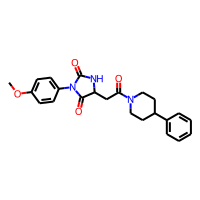
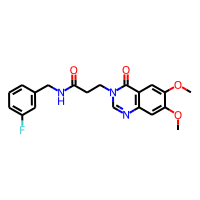

In [ ]:
show(EUOS_db.head(2))

In [ ]:
EU_OS_mol_descs = []
EU_OS_ECFP6s = []
EU_OS_topols = []
EU_OS_atom_pairs = []

euos_pbar = enlighten.Counter(total=len(EUOS_db.index), desc='Encoding EU-OS bioactives', unit='ticks')

for ID, row in EUOS_db.iterrows():
    mol = row.ROMol
    descriptor = desc_calc.CalcDescriptors(mol)

    ECFP6_vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=3)
    topol_vec =  Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)
    atpair_vec = Chem.GetHashedAtomPairFingerprintAsBitVect(mol)

    EU_OS_mol_descs.append(descriptor)
    EU_OS_ECFP6s.append(ECFP6_vec)
    EU_OS_topols.append(topol_vec)
    EU_OS_atom_pairs.append(atpair_vec)

    euos_pbar.update()



In [ ]:
euos_encs = [EU_OS_mol_descs, EU_OS_ECFP6s, EU_OS_topols, EU_OS_atom_pairs]
euos_enc_names = ['descriptors', 'ecfp6s', 'topols', 'at_pairs']

In [ ]:
def evaluate(model, input_data):
    pred_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        input_data
    )
    output = model.predict(pred_dataset)

    return output

In [ ]:
euos_dfs = []

for i in euos_encs:
    arr = np.array(i, dtype=np.float64)
    df = pd.DataFrame(i)

    euos_dfs.append(df)


In [ ]:
predicts = []

for ID,i in enumerate(euos_dfs):
    model = models[ID]
    pred = evaluate(model, i)
    predicts.append(pred)

In [ ]:
for ID, i in enumerate(predicts):
    EUOS_db[euos_enc_names[ID]] = i